# Post-Processing Sampling Results

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [2]:
using ArviZ
using Bump10MSun
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using LaTeXStrings
using Printf
using StatsBase
using StatsPlots
using Trapz
using Turing

## Preliminaries

In [3]:
default(palette=:batlowS)

## Load Traces, Check Convergence

In [4]:
traces = Dict(tuple(k..., sf) => from_netcdf(joinpath(@__DIR__, "..", "chains", "chain" * suffix_map[k] * (sf==default_selection_fraction ? "" : @sprintf("_sel%0.2f", sf)) * ".nc")) for k in keys(suffix_map) for sf in [0.5, 0.9])

Dict{Tuple{MassFunction, PowerLawPairing, Float64}, InferenceData{(:posterior, :sample_stats)}} with 6 entries:
  (GaussianMF(), PowerLawP… => InferenceData{(:posterior, :sample_stats), Tuple…
  (PowerLawGaussian(), Pow… => InferenceData{(:posterior, :sample_stats), Tuple…
  (PowerLawGaussian(), Pow… => InferenceData{(:posterior, :sample_stats), Tuple…
  (GaussianMF(), PowerLawP… => InferenceData{(:posterior, :sample_stats), Tuple…
  (BrokenPowerLaw(), Power… => InferenceData{(:posterior, :sample_stats), Tuple…
  (BrokenPowerLaw(), Power… => InferenceData{(:posterior, :sample_stats), Tuple…

Let's check for convergence:

In [5]:
for (k, t) in pairs(traces)
    println(k)
    @printf("  Min Neff_sel = %.1f (4*Nobs = %d)\n", minimum(t.posterior[:Neff_sel]), 4*length(t.posterior.m1s_popwt[draw=At(1), chain=At(1)]))
    @printf("  Min Neff_samps = %.1f\n", minimum(t.posterior[:Neff_samps]))
end

(GaussianMF(), PowerLawPairing(), 0.9)
  Min Neff_sel = 927.2 (4*Nobs = 52)
  Min Neff_samps = 35.3
(PowerLawGaussian(), PowerLawPairing(), 0.9)
  Min Neff_sel = 254.3 (4*Nobs = 52)
  Min Neff_samps = 2.1
(PowerLawGaussian(), PowerLawPairing(), 0.5)
  Min Neff_sel = 367.0 (4*Nobs = 60)
  Min Neff_samps = 4.9
(GaussianMF(), PowerLawPairing(), 0.5)
  Min Neff_sel = 1192.5 (4*Nobs = 60)
  Min Neff_samps = 10.7
(BrokenPowerLaw(), PowerLawPairing(), 0.9)
  Min Neff_sel = 651.8 (4*Nobs = 52)
  Min Neff_samps = 15.2
(BrokenPowerLaw(), PowerLawPairing(), 0.5)
  Min Neff_sel = 1203.9 (4*Nobs = 60)
  Min Neff_samps = 21.8


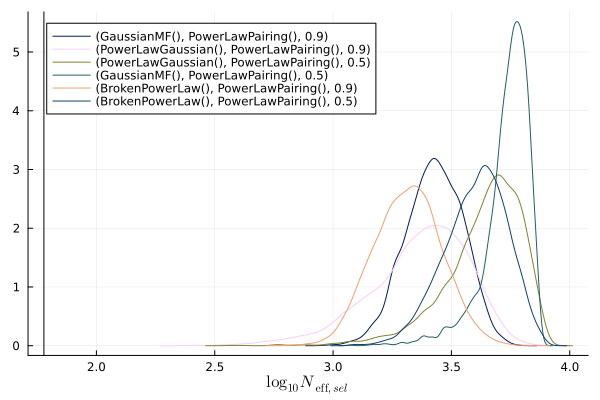

In [6]:
p = plot(xlabel=L"\log_{10} N_{\mathrm{eff}, sel}")
for (k, t) in pairs(traces)
    p = density!(log10.(vec(t.posterior.Neff_sel)), label=string(k))
end
p = vline!([log10(60)], color=:black, label=nothing)
p

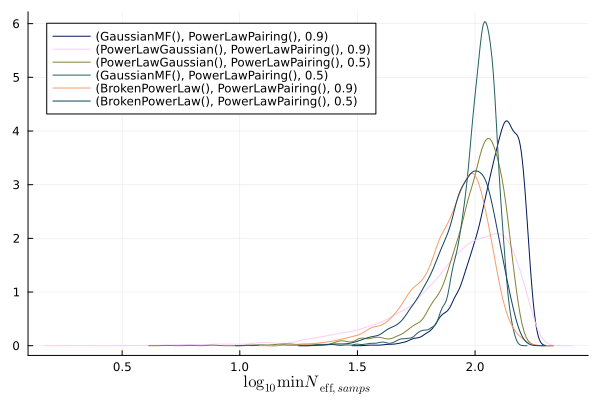

In [7]:
p = plot(xlabel=L"\log_{10} \min N_{\mathrm{eff}, samps}")
for (k, t) in pairs(traces)
    p = density!(log10.(vec(minimum(t.posterior.Neff_samps, dims=:gwnames))), label=string(k))
end
p

And we can take a quick look at the traceplots:

(GaussianMF(), PowerLawPairing(), 0.9)
(PowerLawGaussian(), PowerLawPairing(), 0.9)
(PowerLawGaussian(), PowerLawPairing(), 0.5)
(GaussianMF(), PowerLawPairing(), 0.5)
(BrokenPowerLaw(), PowerLawPairing(), 0.9)
(BrokenPowerLaw(), PowerLawPairing(), 0.5)


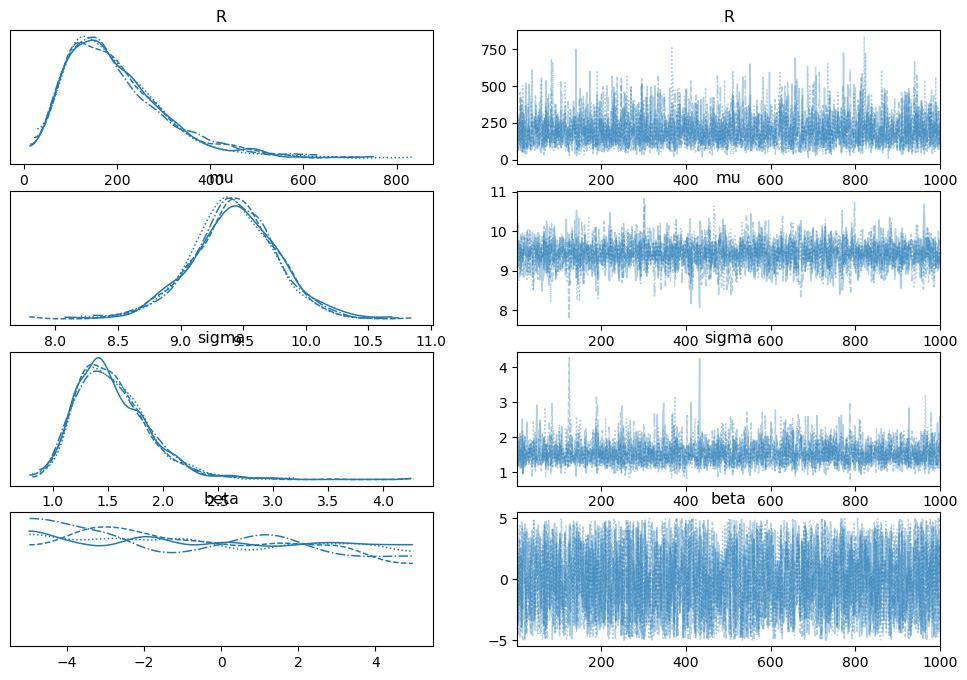

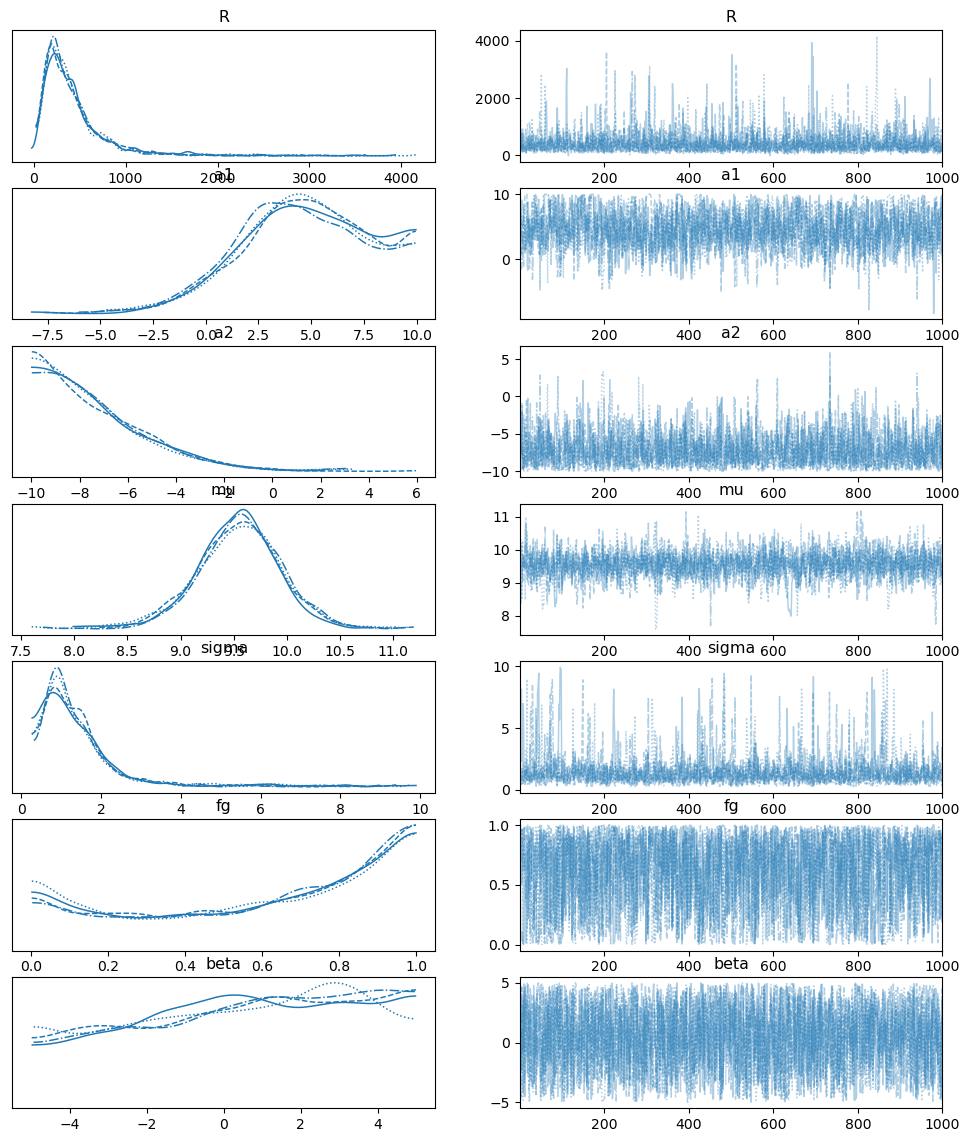

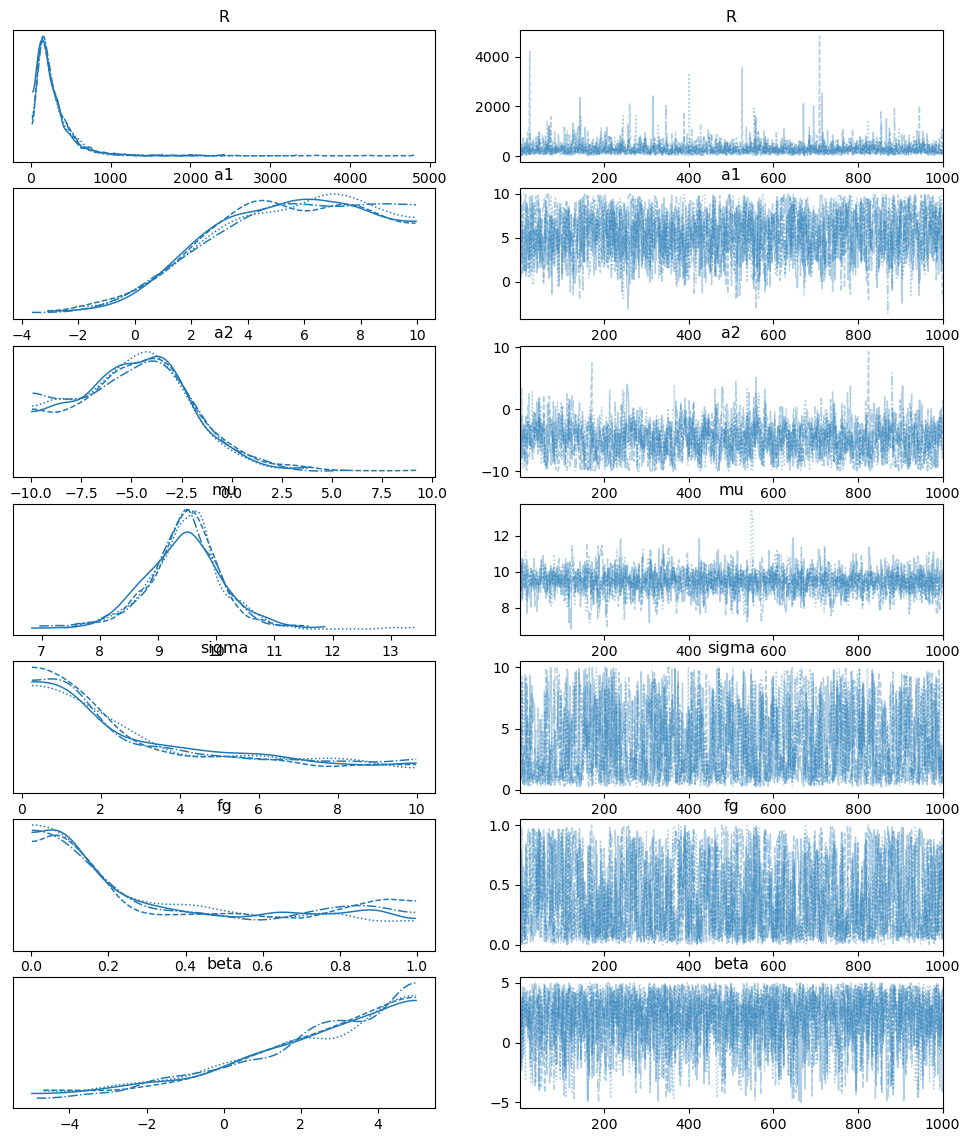

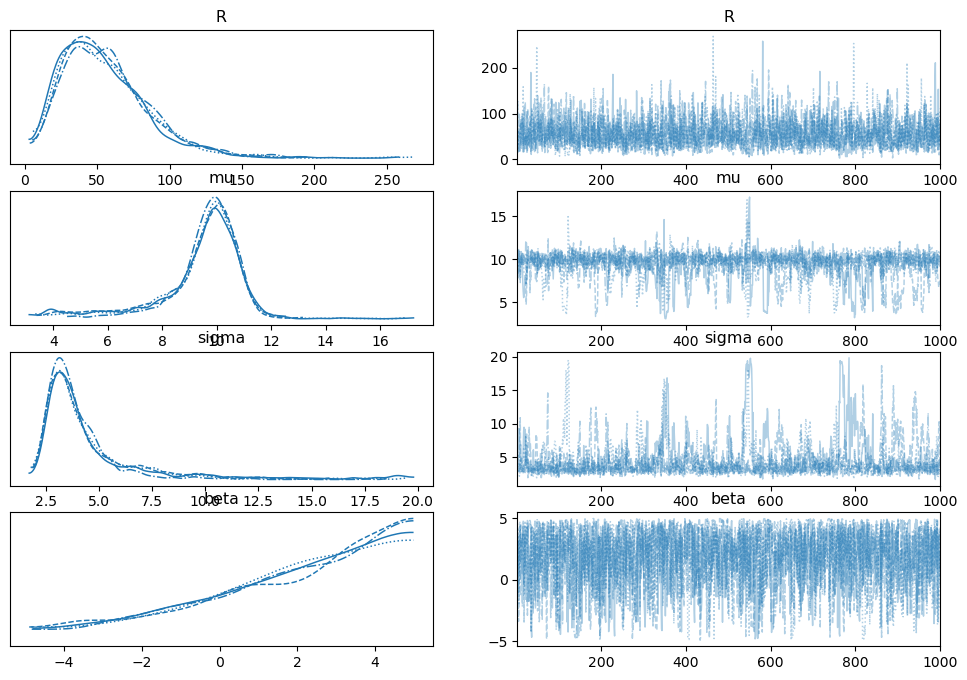

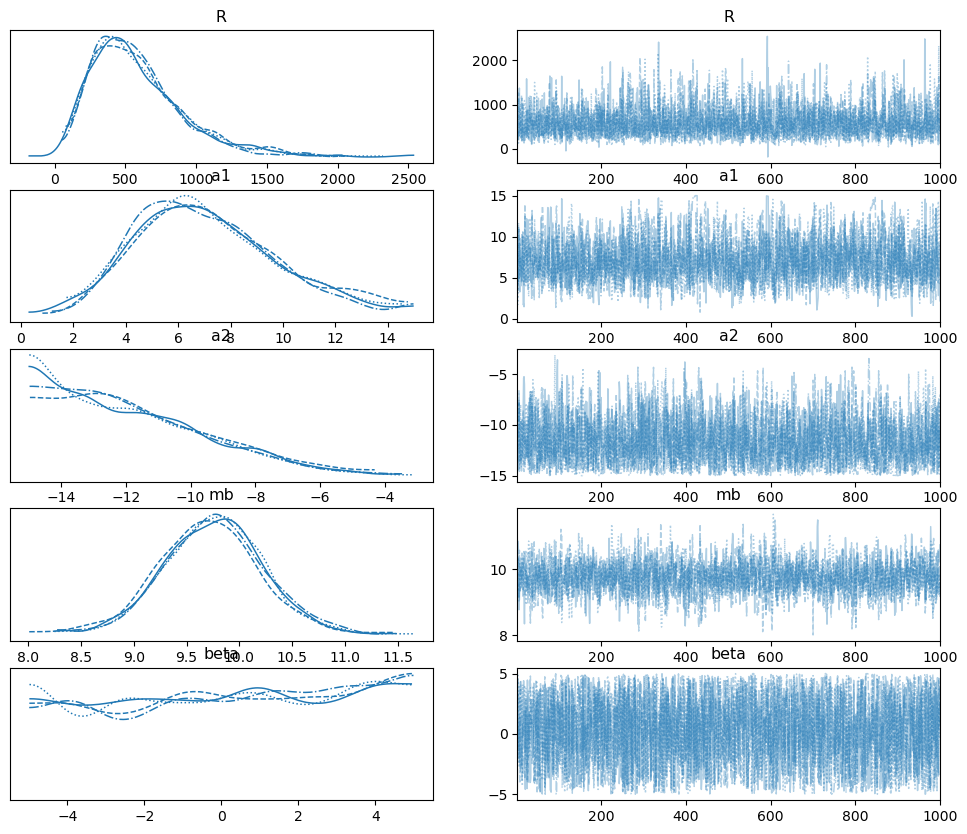

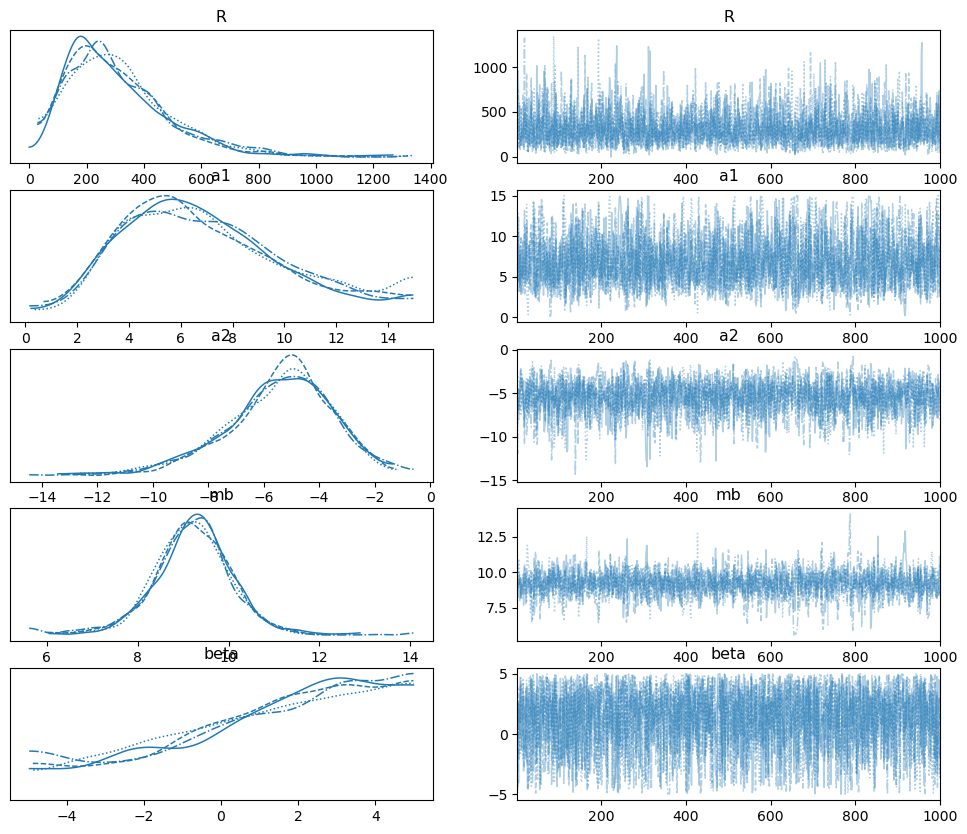

In [8]:
for (k, t) in pairs(traces)
    println(k)
    plot_trace(t, var_names=var_name_map[k[1:2]])
end

In [9]:
for (k, t) in pairs(traces)
    println(k)
    display(summarystats(t, var_names=var_name_map[k[1:2]]))
end

(GaussianMF(), PowerLawPairing(), 0.9)


4×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         197.968  107.466   34.308  394.29       1.839    1.307    323 ⋯
   2 │ mu          9.427    0.34     8.786   10.075      0.007    0.005    247
   3 │ sigma       1.544    0.337    1.005    2.182      0.007    0.005    273
   4 │ beta       -0.169    2.878   -4.942    4.309      0.049    0.05     319
                                                               3 columns omitted

(PowerLawGaussian(), PowerLawPairing(), 0.9)


7×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         419.603  369.299   29.453  979.462      7.756    5.611    301 ⋯
   2 │ a1          4.69     2.967   -0.042    9.99       0.09     0.068    100
   3 │ a2         -7.304    2.207   -9.998   -3.306      0.05     0.035    176
   4 │ mu          9.545    0.404    8.803   10.309      0.01     0.007    175
   5 │ sigma       1.465    1.25     0.252    3.194      0.039    0.028    152 ⋯
   6 │ fg          0.609    0.313    0.053    1.0        0.008    0.006    133
   7 │ beta        0.459    2.781   -4.146    4.998      0.053    0.048    247
                                                               3 columns omitted

(PowerLawGaussian(), PowerLawPairing(), 0.5)


7×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         282.125  260.089   20.096  656.233      5.45     3.854    226 ⋯
   2 │ a1          5.496    2.697    1.063    9.959      0.086    0.062     93
   3 │ a2         -4.899    2.767   -9.99    -0.617      0.089    0.065     93
   4 │ mu          9.452    0.66     8.148   10.715      0.018    0.012    153
   5 │ sigma       3.629    2.803    0.253    8.857      0.084    0.06     110 ⋯
   6 │ fg          0.374    0.307    0.0      0.908      0.01     0.007    107
   7 │ beta        2.033    2.325   -2.377    4.999      0.051    0.036    208
                                                               3 columns omitted

(GaussianMF(), PowerLawPairing(), 0.5)


4×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R          55.722   30.12    10.039  110.575      0.759    0.536    119 ⋯
   2 │ mu          9.44     1.55     5.852   11.73       0.081    0.057     60
   3 │ sigma       4.384    2.477    1.946    8.699      0.164    0.116     45
   4 │ beta        1.821    2.422   -2.785    4.993      0.06     0.042    171
                                                               3 columns omitted

(BrokenPowerLaw(), PowerLawPairing(), 0.9)


5×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%   mcse_mean  mcse_sd  ess_ ⋯
     │ String    Float64  Float64  Float64  Float64   Float64    Float64  Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         589.678  334.37    93.822  1207.6        6.21     4.493    29 ⋯
   2 │ a1          7.134    2.702    2.465    12.402      0.069    0.054    16
   3 │ a2        -11.75     2.375  -14.999    -7.572      0.05     0.036    18
   4 │ mb          9.746    0.484    8.836    10.663      0.011    0.008    19
   5 │ beta        0.198    2.914   -4.481     4.883      0.057    0.05     24 ⋯
                                                               3 columns omitted

(BrokenPowerLaw(), PowerLawPairing(), 0.5)


5×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         312.401  183.351   40.652  646.105      3.573    2.594    259 ⋯
   2 │ a1          6.93     3.127    1.724   13.218      0.07     0.054    210
   3 │ a2         -5.449    1.926   -9.138   -1.998      0.043    0.031    198
   4 │ mb          9.209    0.861    7.551   10.783      0.021    0.015    185
   5 │ beta        1.278    2.602   -3.566    5.0        0.047    0.045    293 ⋯
                                                               3 columns omitted

## Mass Functions

In [10]:
dNdm1dm2_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    ldN = make_log_dN(k[1], k[2], args[2:end]...)
    (m1, m2) -> args[1]*exp(ldN(m1, m2))         
end for k in keys(traces))
dNdm1_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm1(k[1], k[2], args[2:end]...)
    m1 -> args[1]*dN(m1)
end for k in keys(traces))
dNdm2_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm2(k[1], k[2], args[2:end]...)
    m2 -> args[1]*dN(m2)
end for k in keys(traces))
dNdq_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdq(k[1], k[2], args[2:end]...)
    q -> args[1]*dN(q)
end for k in keys(traces))
pm_map = Dict(k => map([traces[k].posterior[v] for v in mf_var_name_map[k[1]]]...) do args...
    make_dNdm(k[1], args[2:end]...)
end for k in keys(traces))

Dict{Tuple{MassFunction, PowerLawPairing, Float64}, DimArray{T, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, A, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata} where {T, A<:AbstractMatrix{T}}} with 6 entries:
  (GaussianMF(), PowerLawP… => var"#22#23"{GaussianMF, Tuple{Float64, Float64}}…
  (PowerLawGaussian(), Pow… => var"#22#23"{PowerLawGaussian, NTuple{5, Float64}…
  (PowerLawGaussian(), Pow… => var"#22#23"{PowerLawGaussian, NTuple{5, Float64}…
  (GaussianMF(), PowerLawP… => var"#22#23"{GaussianMF, Tuple{Float64, Float64}}…
  (BrokenPowerLaw(), Power… => var"#22#23"{BrokenPowerLaw, Tuple{Float64, Float…
  (BrokenPowerLaw(), Power… => var"#22#23"{BrokenPowerLaw, Tuple{Float64, Float…

In [11]:
ms = exp.(log(mlow):0.01:log(mhigh))
ms = ms[2:end-1]
qs = collect(range(mlow/mhigh, 1, length=129))[2:end]

function make_mean_map(xs, dN_map)
    Dict(
        k => begin
            dN_mean = zeros(length(xs))
            for dN in v
                dN_mean .= dN_mean .+ dN.(xs)
            end
            dN_mean .= dN_mean ./ length(v)
            dN_mean
        end
        for (k,v) in pairs(dN_map)
    )
end

dN1_mean_map = make_mean_map(ms, dNdm1_map)
dN2_mean_map = make_mean_map(ms, dNdm2_map)
dNq_mean_map = make_mean_map(qs, dNdq_map)

Dict{Tuple{MassFunction, PowerLawPairing, Float64}, Vector{Float64}} with 6 entries:
  (GaussianMF(), PowerLawP… => [4.40669e-5, 0.000121628, 0.000287789, 0.0006512…
  (PowerLawGaussian(), Pow… => [0.00438072, 0.00858988, 0.0139196, 0.0209389, 0…
  (PowerLawGaussian(), Pow… => [0.0496046, 0.0963908, 0.152818, 0.221905, 0.288…
  (GaussianMF(), PowerLawP… => [0.168669, 0.33216, 0.536215, 0.79628, 1.05286, …
  (BrokenPowerLaw(), Power… => [0.000314883, 0.000717202, 0.001338, 0.00230277,…
  (BrokenPowerLaw(), Power… => [0.00875466, 0.0178335, 0.029478, 0.0444192, 0.0…

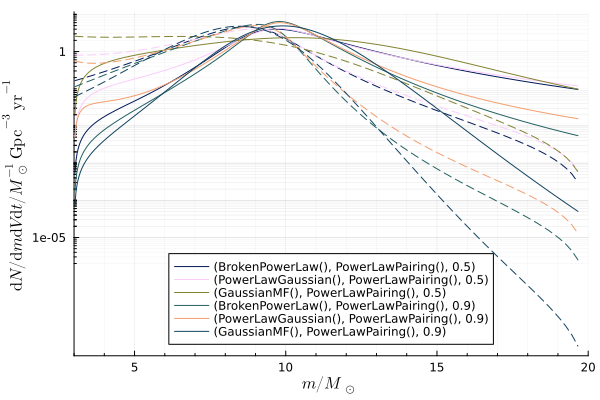

In [12]:
i = 1
p = plot(xlabel=L"m / M_\odot", ylabel=L"\mathrm{d} N / \mathrm{d} m \mathrm{d} V \mathrm{d} t / M_\odot^{-1}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}", formatter=s->@sprintf("%.2g", s), minorgrid=true, xlims=(3, 20))
for sf in [0.5, 0.9]
    for mf in [BrokenPowerLaw(), PowerLawGaussian(), GaussianMF()]
        pf = PowerLawPairing()
        k = (mf, pf, sf)
        v = dN1_mean_map[k]
        p = plot!(ms, v, label=string(k), yscale=:log10, color=i)
        p = plot!(ms, dN2_mean_map[k], label=nothing, color=i, linestyle=:dash)
        i += 1
    end
end
p = plot!(legend_position=:bottom)
p

How about the "common" part of the mass function?

In [13]:
pm_mean_map = Dict(
    k => begin
        pm = zeros(length(ms))
        for v in pm_map[k]
            p = v.(ms)
            p = p ./ trapz(ms, p)
            pm = pm .+ p
        end
        pm = pm / length(pm_map[k])
        pm
    end
    for k in keys(traces)
)

Dict{Tuple{MassFunction, PowerLawPairing, Float64}, Vector{Float64}} with 6 entries:
  (GaussianMF(), PowerLawP… => [0.00165178, 0.0016983, 0.00174691, 0.00179772, …
  (PowerLawGaussian(), Pow… => [0.0172904, 0.0171252, 0.016973, 0.0168335, 0.01…
  (PowerLawGaussian(), Pow… => [0.0321723, 0.0321188, 0.0320708, 0.0320284, 0.0…
  (GaussianMF(), PowerLawP… => [0.0735547, 0.0734774, 0.0734078, 0.0733459, 0.0…
  (BrokenPowerLaw(), Power… => [0.00344414, 0.00352639, 0.00361139, 0.00369924,…
  (BrokenPowerLaw(), Power… => [0.00570977, 0.00580818, 0.00590969, 0.00601441,…

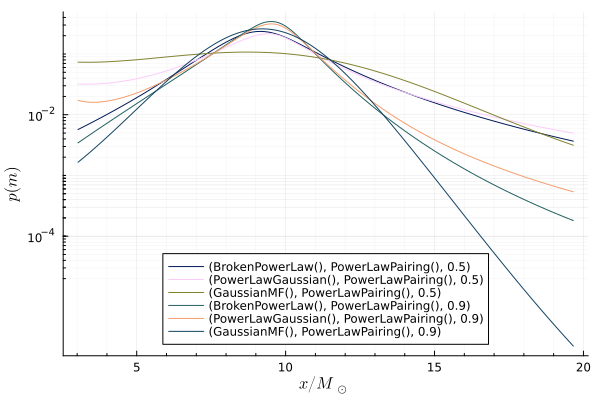

In [14]:
p = plot(xlabel=L"x/M_\odot", ylabel=L"p(m)", yscale=:log10, minorgrid=true, legend_position=:bottom)
for sf in [0.5, 0.9]
    for mf in [BrokenPowerLaw(), PowerLawGaussian(), GaussianMF()]
        k = (mf, PowerLawPairing(), sf)
        v = pm_mean_map[k]
        p = plot!(ms, v, label=string(k))
    end
end
p

What about $\mathrm{d} N / \mathrm{d} q \mathrm{d} V \mathrm{d} t$?

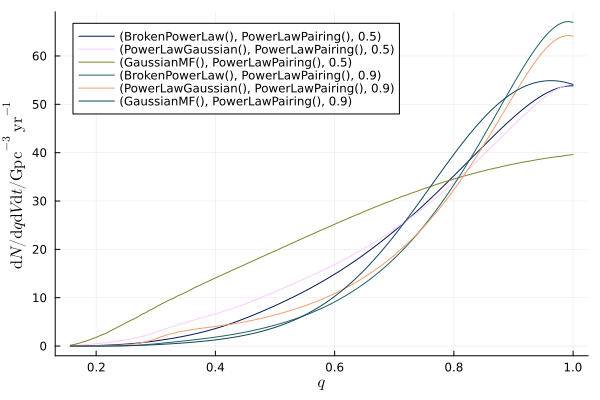

In [15]:
p = plot(xlabel=L"q", ylabel=L"\mathrm{d} N / \mathrm{d} q \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}")

for sf in [0.5, 0.9]
    for mf in [BrokenPowerLaw(), PowerLawGaussian(), GaussianMF()]
        pf = PowerLawPairing()
        k = (mf,pf,sf)

        p = plot!(qs, dNq_mean_map[k], label=string(k))
    end
end
p

## Peak Locations

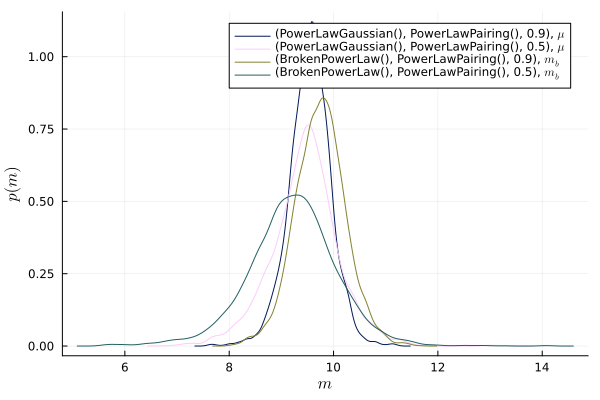

In [16]:
p = plot(xlabel=L"m", ylabel=L"p(m)")
for k in keys(traces)
    if k[1] === BrokenPowerLaw()
        p = density!(vec(traces[k].posterior.mb), label=string(k) * L", $m_b$")
    elseif k[1] === PowerLawGaussian()
        p = density!(vec(traces[k].posterior.mu), label=string(k) * L", $\mu$")
    end
end
p

The Gaussian + Power Law mass scale seems to be the best localized, so let's plot that alone:

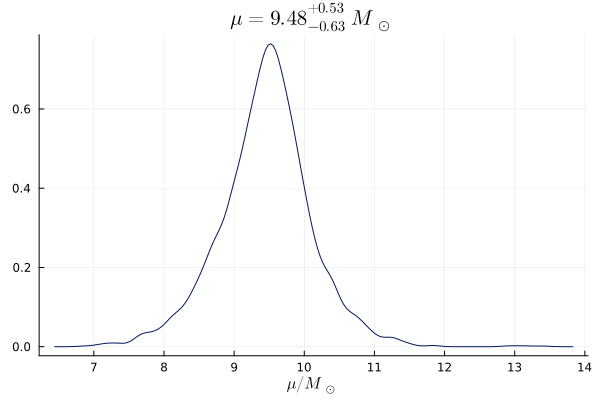

In [17]:
t = traces[(PowerLawGaussian(), PowerLawPairing(), 0.5)]
x = vec(t.posterior.mu)
m = median(x)
l = quantile(x, 0.16)
h = quantile(x, 0.84)

density(x, xlabel=L"\mu / M_\odot", title=@sprintf("\$\\mu = %.3g^{+%.2g}_{-%.2g} \\, M_\\odot\$", m, h-m, m-l), label=nothing)

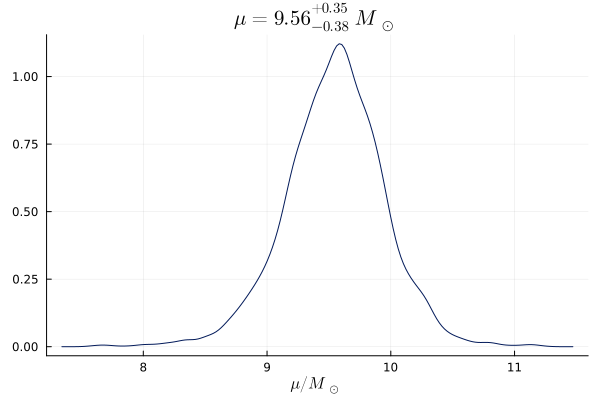

In [18]:
t = traces[(PowerLawGaussian(), PowerLawPairing(), 0.9)]
x = vec(t.posterior.mu)
m = median(x)
l = quantile(x, 0.16)
h = quantile(x, 0.84)

density(x, xlabel=L"\mu / M_\odot", title=@sprintf("\$\\mu = %.3g^{+%.2g}_{-%.2g} \\, M_\\odot\$", m, h-m, m-l), label=nothing)

## $m_{1\%}$

Here again we will look with the Gaussian + Power Law model:

In [19]:
function m1pct(ms, f)
    fm = f.(ms)
    cfm = cumtrapz(ms, fm)

    ms[argmin(abs.(cfm/cfm[end] .- 0.01))]
end

m1pct (generic function with 1 method)

We begin with $m_{1\%}$ for the 50% selection:

In [20]:
m1pct_m1 = Dict(
    k => map(v) do dN
        m1pct(ms, dN)
    end
    for (k,v) in pairs(dNdm1_map)
)
m1pct_m2 = Dict(
    k => map(v) do dN
        m1pct(ms, dN)
    end
    for (k,v) in pairs(dNdm2_map)
)
m1pct_m = Dict(
    k => map(v) do dN
        m1pct(ms, dN)
    end
    for (k,v) in pairs(pm_map)
)

Dict{Tuple{MassFunction, PowerLawPairing, Float64}, DimArray{Float64, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, Matrix{Float64}, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata}} with 6 entries:
  (GaussianMF(), PowerLawP… => [6.74372 5.92163 5.04608 5.25202; 4.84822 4.5204…
  (PowerLawGaussian(), Pow… => [5.35812 4.43094 3.24986 3.18551; 3.45082 3.7382…
  (PowerLawGaussian(), Pow… => [4.00928 3.28252 3.21752 4.09028; 7.37881 3.1855…
  (GaussianMF(), PowerLawP… => [3.15381 3.12243 3.31551 3.45082; 3.12243 3.1224…
  (BrokenPowerLaw(), Power… => [3.28252 5.57678 5.25202 6.4793; 4.75222 3.18551…
  (BrokenPowerLaw(), Power… => [4.65812 5.46636 6.28781 4.52045; 6.351 3.92989 …

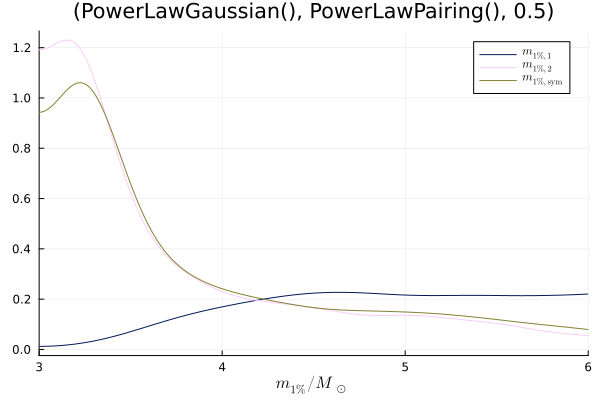

In [21]:
m1ps = 3:0.01:6
ymax = 1.6

k = (PowerLawGaussian(), PowerLawPairing(), 0.5)

p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 6), title=string(k))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
end
p

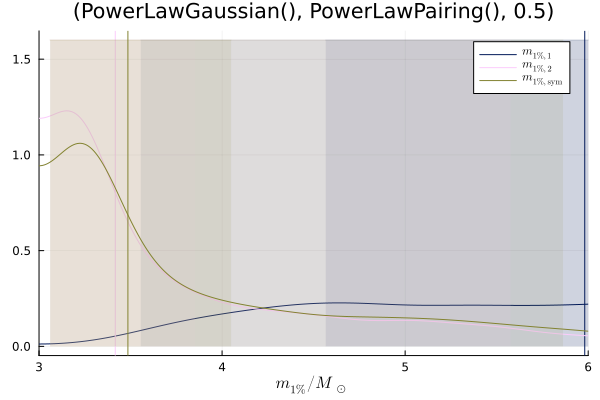

In [22]:
m1ps = 3:0.01:6
ymax = 1.6
p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 6), title=string(k))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
    p = vline!([median(m)], color=i, label=nothing)

    l,h = hdi_interval(m, 0.68)
    ll, hh = hdi_interval(m, 0.95)
    p = plot!([l, h], [ymax, ymax], fillrange=[0, 0], color=i, alpha=0.1, label=nothing)
    p = plot!([ll,hh], [ymax, ymax], fillrange=[0, 0], color=i, alpha=0.1, label=nothing)
end
p

And for the 90% selection:

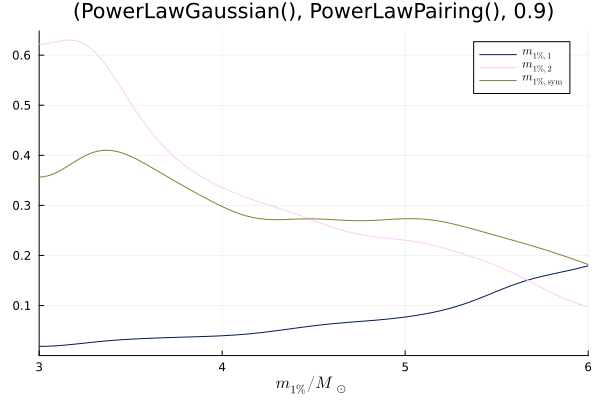

In [23]:
k = (PowerLawGaussian(), PowerLawPairing(), 0.9)
m1ps = 3:0.01:6
ymax = 1.6
p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 6), title=string(k))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
end
p

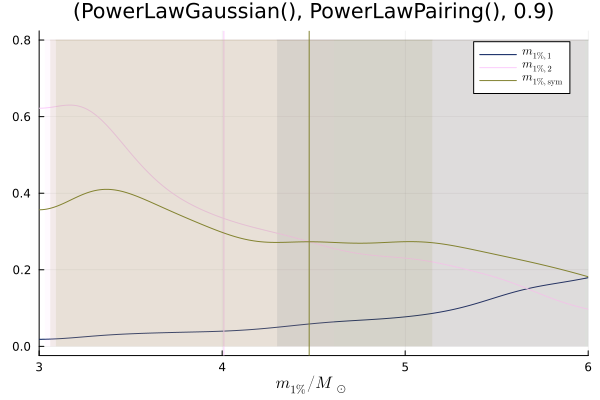

In [24]:
m1ps = 3:0.01:6
ymax = 0.8
p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 6), title=string(k))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
    p = vline!([median(m)], color=i, label=nothing)

    l,h = hdi_interval(m, 0.68)
    ll, hh = hdi_interval(m, 0.95)
    p = plot!([l, h], [ymax, ymax], fillrange=[0, 0], color=i, alpha=0.1, label=nothing)
    p = plot!([ll,hh], [ymax, ymax], fillrange=[0, 0], color=i, alpha=0.1, label=nothing)
end
p

In [31]:
for sf = [0.5, 0.9]
    k = (PowerLawGaussian(), PowerLawPairing(), sf)
    m1p = m1pct_m[k]
    m = median(vec(m1p))
    l,h = hdi_interval(vec(m1p), 0.68)
    ll, hh = hdi_interval(vec(m1p), 0.95)

    @printf("%s: m_1%% = %.2f + %.2f - %.2f (1-sigma) or [%.1f - %.1f] (2-sigma)\n", string(k), m, h-m, m-l, ll, hh)
end

(PowerLawGaussian(), PowerLawPairing(), 0.5): m_1% = 3.49 + 0.56 - 0.42 (1-sigma) or [3.1 - 5.9] (2-sigma)
(PowerLawGaussian(), PowerLawPairing(), 0.9): m_1% = 4.48 + 0.67 - 1.38 (1-sigma) or [3.1 - 6.5] (2-sigma)


## Individual Masses

Let's do some model checking.  First, we plot the population-informed posteriors for $m_1$ and $m_2$:

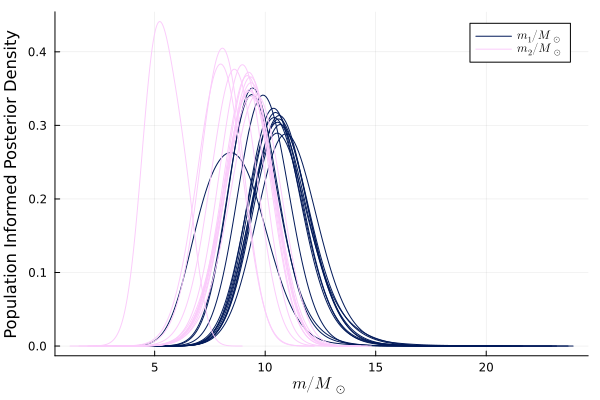

In [25]:
p = plot(xlabel=L"m / M_\odot", ylabel="Population Informed Posterior Density")
m1label = L"m_1 / M_\odot"
for n in DimensionalData.index(t.posterior, :gwnames)
    x = vec(t.posterior.m1s_popwt[gwnames=At(n)])
    p = density!(x, color=1, label=m1label, bandwidth=0.1*median(x))
    m1label = nothing
end
m2label = L"m_2 / M_\odot"
for n in DimensionalData.index(t.posterior, :gwnames)
    x = vec(t.posterior.m2s_popwt[gwnames=At(n)])
    p = density!(x, color=2, label=m2label, bandwidth=0.1*median(x))
    m2label = nothing
end
p

I bet our inference about the minimum BH mass is being driven by that one outlier.  Let's look:

In [26]:
nmin = ""
mmin = Inf
for n in DimensionalData.index(t.posterior, :gwnames)
    mm = minimum(t.posterior.m2s_popwt[gwnames=At(n)])

    if mm < mmin
        mmin = mm
        nmin = n
    end
    println("minimum(m2, $(n)): $(mm)")
end

println("Overall minimum is $(nmin)")

minimum(m2, GW190707_093326): 6.158598813976253
minimum(m2, GW190720_000836): 6.530061903912733
minimum(m2, GW190728_064510): 5.771058564092116
minimum(m2, GW190924_021846): 3.2858121413261565
minimum(m2, GW190930_133541): 5.626936836624729
minimum(m2, GW191103_012549): 6.263093569094577
minimum(m2, GW191105_143521): 5.7903470404752335
minimum(m2, GW191126_115259): 5.837094407601558
minimum(m2, GW191129_134029): 4.764116251265516
minimum(m2, GW191204_171526): 6.58280644097665
minimum(m2, GW191216_213338): 6.2868194653288
minimum(m2, GW200202_154313): 5.444258977060994
minimum(m2, GW200316_215756): 6.574855927117844
Overall minimum is GW190924_021846


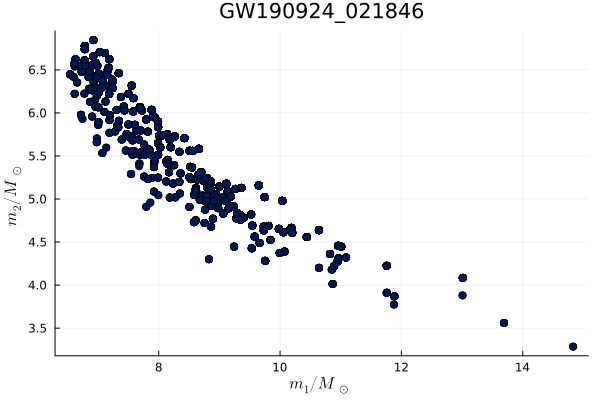

In [27]:
post = t.posterior
scatter(vec(post.m1s_popwt[gwnames=At(nmin)]), vec(post.m2s_popwt[gwnames=At(nmin)]), label=nothing, xlabel=L"m_1 / M_\odot", ylabel=L"m_2 / M_\odot", title=nmin)